In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity


In [27]:
# Load datasets with error handling
try:
    C = pd.read_csv("Customers.csv")
    P = pd.read_csv("Products.csv")
    T = pd.read_csv("Transactions.csv")
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure Customers.csv, Products.csv, and Transactions.csv are in the working directory.")
    exit(1)

In [29]:
# Merge datasets
ptc = T.merge(P, on="ProductID").merge(C, on="CustomerID")
ptc.rename(columns={"Price_x": "Price"}, inplace=True)
ptc.drop(columns=["Price_y"], inplace=True)
print(f"Merged dataset shape: {ptc.shape}")

In [31]:
# Feature engineering
total_spending = ptc.groupby("CustomerID")["TotalValue"].sum().reset_index()
transaction_count = ptc.groupby("CustomerID")["TransactionID"].count().reset_index()
transaction_count.rename(columns={"TransactionID": "TransactionCount"}, inplace=True)
avg_spending = total_spending.merge(transaction_count, on="CustomerID")
avg_spending["AvgSpendingPerTransaction"] = avg_spending["TotalValue"] / avg_spending["TransactionCount"]

In [33]:
# Check for NaNs in avg_spending
print("NaNs in avg_spending:\n", avg_spending.isna().sum())

In [47]:
# Add average days between purchases
ptc["TransactionDate"] = pd.to_datetime(ptc["TransactionDate"])
ptc = ptc.sort_values(["CustomerID", "TransactionDate"])
ptc["prev_purchase"] = ptc.groupby("CustomerID")["TransactionDate"].shift(1)
ptc["days_between"] = (ptc["TransactionDate"] - ptc["prev_purchase"]).dt.days

In [49]:

# Fill NaNs in days_between with median (excluding NaNs)
median_days = ptc["days_between"].median()
ptc["days_between"] = ptc["days_between"].fillna(median_days)
avg_days = ptc.groupby("CustomerID")["days_between"].mean().reset_index()
print("NaNs in avg_days:\n", avg_days.isna().sum())

NaNs in avg_days:
 CustomerID      0
days_between    0
dtype: int64


In [51]:

# Combine features
features = avg_spending[["CustomerID", "TotalValue", "TransactionCount", "AvgSpendingPerTransaction"]]
features = features.merge(avg_days, on="CustomerID")

In [53]:
# Add region
features = features.merge(ptc[["CustomerID", "Region"]].drop_duplicates(), on="CustomerID")
features = pd.get_dummies(features, columns=["Region"], drop_first=True)

In [55]:
# Check for NaNs in features before scaling
print("NaNs in features before scaling:\n", features.isna().sum())
print(f"Features shape: {features.shape}")

NaNs in features before scaling:
 CustomerID                   0
TotalValue                   0
TransactionCount             0
AvgSpendingPerTransaction    0
days_between                 0
Region_Europe                0
Region_North America         0
Region_South America         0
dtype: int64
Features shape: (199, 8)


In [57]:
# Standardize numerical features
scaler = StandardScaler()
numerical_cols = ["TotalValue", "TransactionCount", "AvgSpendingPerTransaction", "days_between"]
features[numerical_cols] = scaler.fit_transform(features[numerical_cols])

In [59]:
# Check for NaNs after scaling
print("NaNs in features after scaling:\n", features.isna().sum())

NaNs in features after scaling:
 CustomerID                   0
TotalValue                   0
TransactionCount             0
AvgSpendingPerTransaction    0
days_between                 0
Region_Europe                0
Region_North America         0
Region_South America         0
dtype: int64


In [61]:
# Compute cosine similarity
try:
    similarity_matrix = cosine_similarity(features.drop("CustomerID", axis=1))
except ValueError as e:
    print(f"Error in cosine_similarity: {e}")
    print("Check features for NaNs or non-numeric values.")
    exit(1)

similarity_df = pd.DataFrame(similarity_matrix, index=features["CustomerID"], columns=features["CustomerID"])

In [63]:
# Generate top 5 similar customers
lookalike = []
for customer in similarity_df.index:
    similar = similarity_df.loc[customer].sort_values(ascending=False)[1:6]
    for similar_customer, score in similar.items():
        lookalike.append({"CustomerID": customer, "SimilarCustomerID": similar_customer, "SimilarityScore": score})

lookalike_df = pd.DataFrame(lookalike)
lookalike_df.to_csv("Lookalike.csv", index=False)
print("Saved lookalike recommendations to Lookalike.csv")

Saved lookalike recommendations to Lookalike.csv


Text(0, 0.5, 'Frequency')

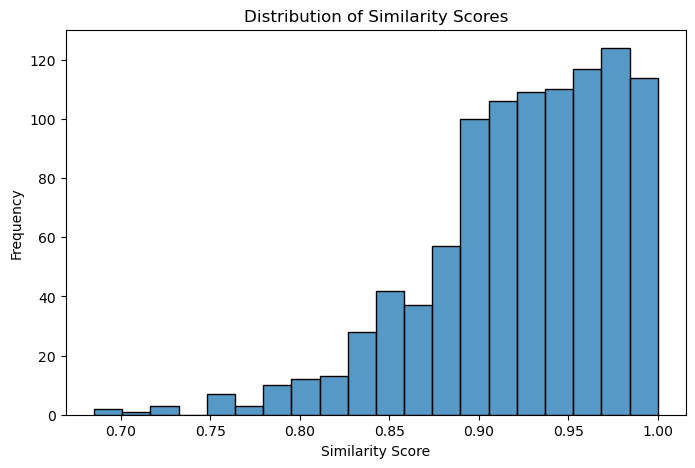

In [67]:
# Visualize similarity scores
plt.figure(figsize=(8, 5))
sns.histplot(lookalike_df["SimilarityScore"], bins=20)
plt.title("Distribution of Similarity Scores")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")

In [69]:
plt.savefig("similarity_scores.png")
plt.close()
print("Saved similarity score visualization to similarity_scores.png")

Saved similarity score visualization to similarity_scores.png
